# Value At Risk (위험 가치)

Value At Risk (VaR) 또는 "위험 가치"는 투자 포트폴리오에서 일정 기간 동안 발생할 수 있는 최대 예상 손실을 측정하는 데 사용되는 금융 위험 관리 도구입니다. VaR은 주어진 확률과 시간 기간에 대한 손실의 최대 금액을 나타냅니다.

예를 들어, 1일 VaR이 1백만 달러, 5%라고 한다면, 이는 하루에 1백만 달러 이상 손실이 발생할 확률이 5%라는 의미입니다. 다시 말해, 100일 중 약 5일 동안 투자자는 1백만 달러 이상 손실을 볼 수 있다는 것을 예상할 수 있습니다.

- VaR은 일반적으로 세 가지 요소를 고려하여 계산됩니다:  
1. 확률 또는 신뢰 수준(Confidence level): 손실이 예상치를 초과할 확률.  
2. 시간 기간(Time horizon): VaR 측정치를 기반으로 하는 기간.  
3. 손실 금액(Loss amount): 주어진 확률과 시간 기간 동안 손실될 수 있는 금액.  

VaR은 자산, 포트폴리오, 회사 또는 금융 기관의 위험을 측정하고 이해하는 데 유용한 도구이지만, 극단적인 이벤트(즉, "꼬리" 위험)를 잘 포착하지 못하는 한계가 있습니다. 따라서 VaR은 종종 다른 위험 관리 지표와 함께 사용됩니다.

### APPLE 주식의 로그 수익률 분포

- histogram 으로 확인하면 normal distribution 에 매우 가깝게 나타난다.
- Mean(mu), variance(sigma) 를 historic data 로부터 추정

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import FinanceDataReader as fdr

# ticker = 'AAPL'  
# ticker_name = "Apple"

ticker = '086520'  
ticker_name = "Echo Pro"

In [2]:
df = fdr.DataReader(ticker, start="2020-01-01")
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,14595,14854,14271,14790,623562,0.017754
2020-01-03,14757,14757,14400,14564,443667,-0.015281
2020-01-06,14141,14886,14013,14726,700990,0.011123
2020-01-07,14660,14983,14466,14499,415685,-0.015415
2020-01-08,14400,14499,13819,13917,721077,-0.040141


- 로그 수익률 계산

In [3]:
df['LogReturn'] = np.log(df['Close']) - np.log(df['Close'].shift(1))
df.head()

,Open,High,Low,Close,Volume,Change,LogReturn
Date,,,,,,,
2020-01-02,14595,14854,14271,14790,623562,0.017754,NaN
2020-01-03,14757,14757,14400,14564,443667,-0.015281,-0.015399
2020-01-06,14141,14886,14013,14726,700990,0.011123,0.011062
2020-01-07,14660,14983,14466,14499,415685,-0.015415,-0.015535
2020-01-08,14400,14499,13819,13917,721077,-0.040141,-0.040969


<Axes: xlabel='Date'>

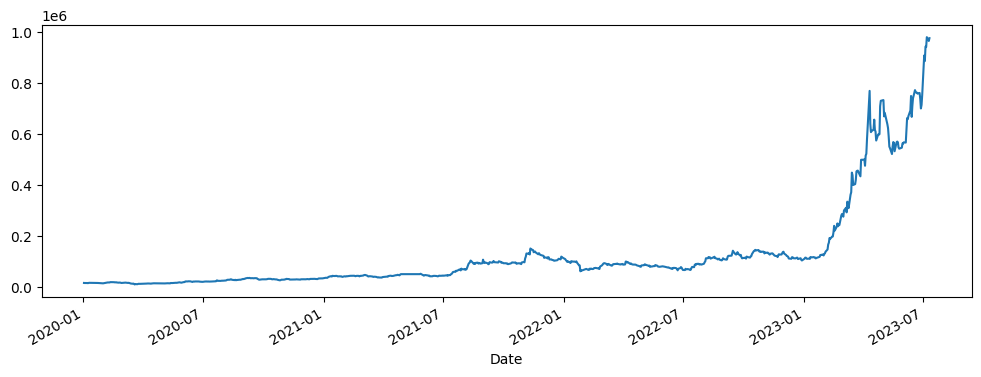

In [4]:
df['Close'].plot(figsize=(12, 4))

<Axes: xlabel='Date'>

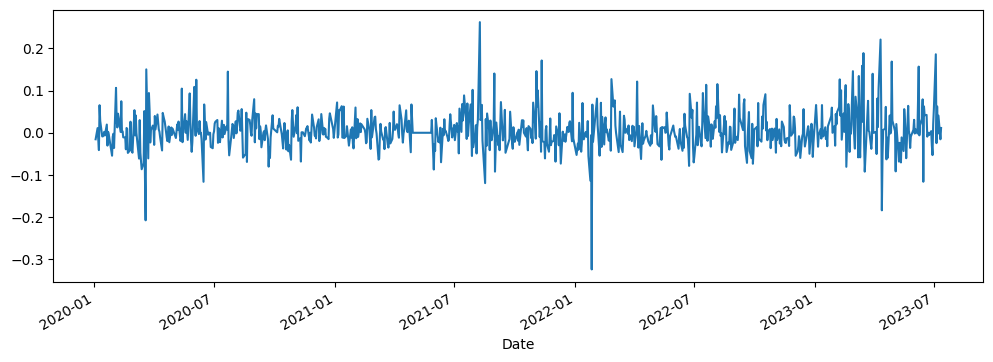

In [5]:
df['LogReturn'].plot(figsize=(12, 4))

- 로그 수익률의 평균, 표준편차 계산  

표본 표준편차의 경우 공식에서 `n – 1` (ddof=1)을 사용합니다. n을 사용하면 변동성을 일관되게 과소평가하는 편향된 추정치를 얻을 수 있기 때문입니다. 표본 표준 편차는 모집단의 실제 표준 편차보다 낮은 경향이 있습니다.  
표본 n을 n – 1로 줄이면 표준 편차가 인위적으로 커지므로 보수적인 변동성 추정치를 얻을 수 있습니다.

In [7]:
mu = df['LogReturn'].mean()
sigma = df['LogReturn'].std(ddof=1)  # sample - 1

print(f"{ticker_name}의 일일 수익률 평균은 {mu:.5f} 이고, 표준 편차는 {sigma: .5f}이다")

에코프로의 일일 수익률 평균은 0.00481 이고, 표준 편차는  0.04522이다


### 수익률 분포 시각화

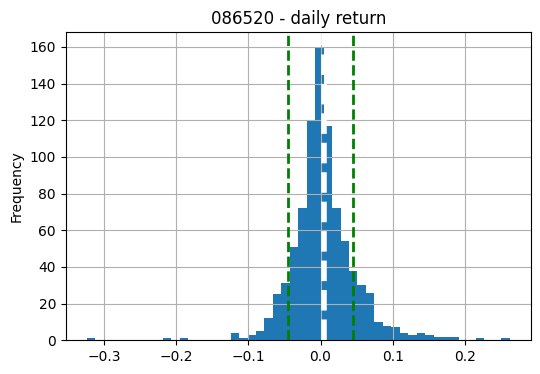

In [8]:
# histogram
df['LogReturn'].plot(kind='hist', bins=50, figsize=(6, 4))

# 수직선으로 평균, 표준편차 표시
plt.axvline(mu, color='w', linestyle='dashed', linewidth=4)
plt.axvline(sigma, color='g', linestyle='dashed', linewidth=2)
plt.axvline(-sigma, color='g', linestyle='dashed', linewidth=2)
plt.title(f"{ticker} - daily return")

plt.grid()

### 확률밀도함수(probability density function) 시각화
- 확률밀도 함수의 95% 신뢰구간 시각화

In [11]:
denApp = pd.DataFrame()
# x의 범위를 지정
denApp['x'] = np.arange(df['LogReturn'].min() - 0.01, df['LogReturn'].max() + 0.01, 0.001)
# 정규 분포의 확률 밀도 함수를 이용해 y 값을 계산하고, 이를 'pdf' 컬럼에 저장
denApp['pdf'] = norm.pdf(denApp['x'], mu, sigma)

denApp.head()  

,x,pdf
0,-0.33354,6.126870e-12
1,-0.33254,7.227717e-12
2,-0.33154,8.522190e-12
3,-0.33054,1.004359e-11
4,-0.32954,1.183080e-11


- 정규분포에 따른 확률 밀도 함수

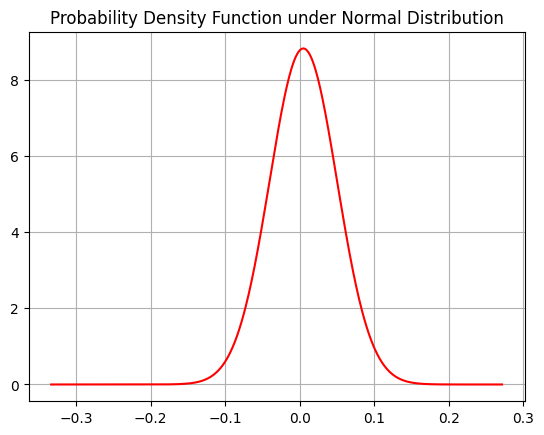

In [13]:
plt.plot(denApp['x'], denApp['pdf'], color='red')
plt.grid() 
plt.title("Probability Density Function under Normal Distribution")
plt.show() 

### APPL 주식이 하루에 x% 이상 하락할 확률 계산

- 누적 분포 함수(Cumulative distribution function, cdf)는 주어진 특정 값보다 작거나 같은 확률을 나타내는 함수이다.   
 

- `norm.cdf` 함수는 누적 분포 함수(cumulative distribution function)를 나타내며, 특정 값 이하의 확률을 반환.  
    - 사용 방법 - norm.cdf(z-score) or norm.cdf(X, mu, sigma) --> Probability

예) 하루 5% 이상 하락할 확률 $\rightarrow$  -0.05 이하의 값이 나올 확률

In [16]:
#평균이 mu이고 표준편차가 sigma인 정규분포에서 -0.05 이하의 값이 나올 확률# 
prob = norm.cdf(-0.05, mu, sigma)
print(f'평균이 {mu:.3f}이고 표준편차가 {sigma:.3f}일 때 ' + 
          f'-0.05 보다 작거나 같을 확률은 {prob * 100:.2f} % 이다.')

평균이 0.005이고 표준편차가 0.045일 때 -0.05 보다 작거나 같을 확률은 11.27 % 이다.


- 하루에 10% 이상 하락할 확률 $\rightarrow$  -0.1 이하의 값이 나올 확률

In [18]:
prob = norm.cdf(-0.1, mu, sigma)
print('The Probability is {:.2f} %'.format(prob * 100))

The Probability is 1.02 %


- 하루 1% 이상 하락할 확률

In [22]:
prob = norm.cdf(-0.01, mu, sigma)
print('The Probability is {:.10f} %'.format(prob * 100))

The Probability is 37.1633841300 %


위에서 계산한 확률을 시각화

Text(0.5, 1.0, 'Probability of Echo Pro - 10% down a day')

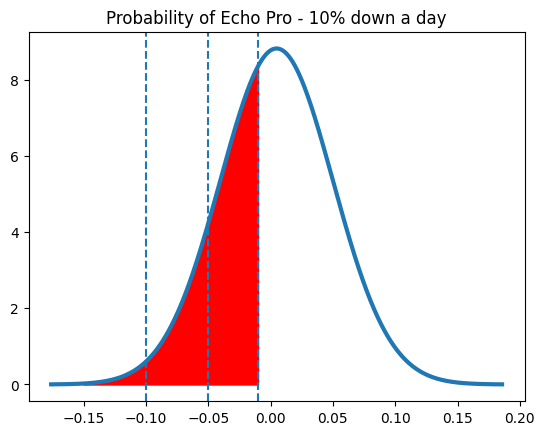

In [27]:
# 평균이 mu이고 표준편차가 sigma인 정규분포 객체를 생성합니다.
iq = norm(mu, sigma)

# mu 주위에 4*sigma 범위의 값을 가진 배열을 생성합니다.
x = np.arange(mu-4*sigma, mu+4*sigma, 0.00001)

# 확률 밀도 함수를 그립니다.
plt.plot(x, iq.pdf(x), linewidth=3)

# x 축에서 -0.01, -0.05, -0.1 위치에 수직선을 그립니다.
plt.axvline(-0.01, ls='--')
plt.axvline(-0.05, ls='--')
plt.axvline(-0.1, ls='--')

# x 축에서 -0.15에서 -0.01 사이의 값을 가진 배열을 생성합니다.
xrange = np.arange(-0.15, -0.01, 0.0001)

# 해당 범위에서 확률 밀도 함수 아래 영역을 채워 시각화합니다.
plt.fill_between(xrange, y1=norm.pdf(xrange, mu, sigma), y2=0, color='red')

plt.title(f"Probability of {ticker_name} - 10% down a day")

### APPL 주식이 일년(220 거래일)에 xx% 이상 하락할 확률 계산

- `mu`가 daily return의 평균이므로 220 거래일의 평균 return 은 $220 \times mu $
- `sigma`가 daily return의 표준편차이므로 220 거래일의 표준편차는 $\sqrt{220} \times \sigma$

- 1년에 xx% 이상 하락할 확률

In [29]:
mu220 = 220 * mu
sigma220 = (220 ** 0.5) * sigma

#평균이 mu220이고 표준편차가 sigma220인 정규분포에서 -0.1 이하의 값이 나올 확률
p = norm.cdf(-0.1, mu220, sigma220)*100
print('1년에 10% 이상 하락할 확률 {:.2f}% '.format(p))
#평균이 mu220이고 표준편차가 sigma220인 정규분포에서 -0.2 이하의 값이 나올 확률
p = norm.cdf(-0.2, mu220, sigma220)*100
print('1년에 20% 이상 하락할 확률 {:.2f}% '.format(p))
#평균이 mu220이고 표준편차가 sigma220인 정규분포에서 -0.3 이하의 값이 나올 확률
p = norm.cdf(-0.4, mu220, sigma220)*100
print('1년에 40% 이상 하락할 확률 {:.2f}%'.format(p))

1년에 10% 이상 하락할 확률 4.21% 
1년에 20% 이상 하락할 확률 3.03% 
1년에 40% 이상 하락할 확률 1.48%


- APPL 주식이 일년(220 거래일)에 xx% 이상 하락할 확률 확률 시각화

Text(0.5, 1.0, 'Probability of Echo Pro - 10% down a year')

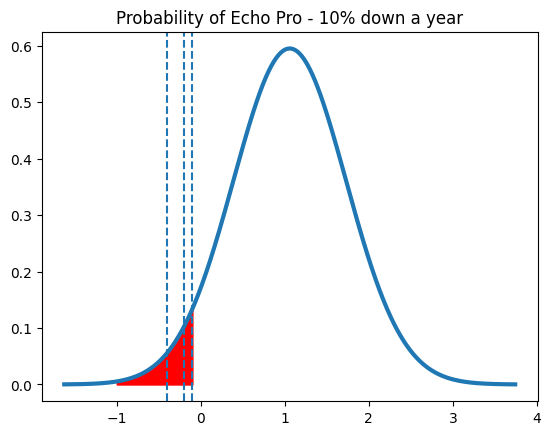

In [30]:
# 평균이 mu220이고 표준편차가 sigma220인 정규분포 객체를 생성합니다.
iq = norm(mu220, sigma220)

# mu220 주위에 4*sigma220 범위의 값을 가진 배열을 생성합니다.
x = np.arange(mu220 - 4*sigma220, mu220 + 4*sigma220, 0.00001)

# 확률 밀도 함수를 그립니다.
plt.plot(x, iq.pdf(x), linewidth=3)

# x 축에서 -0.1, -0.2, -0.4 위치에 수직선을 그립니다.
plt.axvline(-0.1, ls='--')
plt.axvline(-0.2, ls='--')
plt.axvline(-0.4, ls='--')

# x 축에서 -1.0에서 -0.1 사이의 값을 가진 배열을 생성합니다.
xrange = np.arange(-1.0, -0.1, 0.0001)

# 해당 범위에서 확률 밀도 함수 아래 영역을 채워 시각화합니다.
plt.fill_between(xrange, y1=iq.pdf(xrange), y2=0, color='red')

plt.title(f"Probability of {ticker_name} - 10% down a year")

## Value at risk (VaR, 위험 가치) 계산
- 발생 가능 최대 손실 : 투자 손실의 위험 표시

- 일일 수익률의 5% 분위수(quantile)를 95% VaR 또는 95% 수준의 VaR이라고 합니다.   
$\rightarrow$  '95% 확률로 우리의 일일 수익률 손실이 이 VaR 값 이하일 것'이라는 의미. 동시에 이 값을 초과하여 손실이 발생할 확률이 5% 라는 의미.

**VaR = norm.ppf(significance_level, mu, sigma)**

 significance_level은 VaR 계산에서 "우리가 고려하는 특정 위험 수준"을 의미합니다. 예를 들어, significance_level이 0.05(또는 5%)라면, 이는 "95%의 확신 수준에서 고려하는 최악의 손실"을 의미하며, **5%의 확률**로 그보다 더 큰 손실이 발생할 수 있음을 의미합니다. 다시 말해, "5%의 확률로 발생할 수 있는 최대 손실"을 의미.

유의 수준(가능성) 5%에서 VaR 계산 $\rightarrow$ Probability 0.05가 되는 z-score 값 계산과 동일한 의미

In [48]:
significance_level = 0.05
VaR = norm.ppf(significance_level, mu, sigma)

print('평균 수익률 {:.5f}, 변동성 {:.5f} 인 주식은 {}%의 확률로 daily return 이 {:.3f} 보다 나쁠 수 있다. '
          .format(mu, sigma, significance_level*100, VaR))  

평균 수익률 0.00481, 변동성 0.04522 인 주식은 5.0%의 확률로 daily return 이 -0.070 보다 나쁠 수 있다. 


유의 수준(가능성)을 1%로 낮추면 VaR 증가

In [50]:
significance_level = 0.01
VaR = norm.ppf(significance_level, mu, sigma)

print('평균 수익률 {:.5f}, 변동성 {:.5f} 인 주식은 {}%의 확률로 daily return 이 {:.3f} 보다 나쁠 수 있다. '
          .format(mu, sigma, significance_level*100, VaR))  

평균 수익률 0.00481, 변동성 0.04522 인 주식은 1.0%의 확률로 daily return 이 -0.100 보다 나쁠 수 있다. 
